<a href="https://colab.research.google.com/github/ayrna/ap2122/blob/main/redes_recurrentes/time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizar Keras para construir y entrenar redes LSTM con series temporales

En este cuaderno, vamos a usar keras para construir una red LSTM que resuelva un problema de predicción en series temporales.

El problema que vamos a estudiar es el de predicción de pasajeros de líneas aéreas internacionales. Para este problema se nos da un año y un mes y tenemos que predecir el número de pasajeros de líneas aéreas internacionales en unidades de 1.000. En otras palabras, tenemos que responder a la pregunta: "Dado el número de pasajeros (en unidades de miles) de este mes, ¿cuál será el número de pasajeros del próximo mes?". 

Los datos van de enero de 1949 a diciembre de 1960 con 144 observaciones.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

El siguiente paso es cargar nuestro conjunto de datos de entrenamiento como un `DataFrame` de Pandas. A continuación, podemos extraer la matriz `numpy` del `DataFrame` y convertir los valores enteros en valores de punto flotante, que son más adecuados para el modelado con una red neuronal.

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


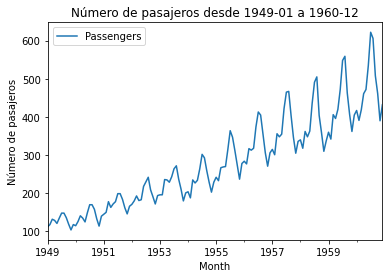

In [2]:
# Cargar el conjunto de datos usando pandas

try:
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
    df = pd.read_csv(url)
except:
    df = pd.read_csv("./data/airline-passengers.csv")

# Dar el formato correcto a la fecha y usarlo como índice
df.Month = pd.to_datetime(df.Month)
df.set_index('Month', inplace=True)

# Mostrar los primeros datos
print(df.head())

# Usar matplotlib para mostrar la serie
df.plot()
plt.title("Número de pasajeros desde 1949-01 a 1960-12")
plt.ylabel("Número de pasajeros")
plt.show()

Las redes LSTM pueden ser sensibles a la escala de los datos de entrada. Puede ser buena idea rescalar los datos en el rango [0,1]. Para ello, vamos a usar `MinMaxScaler`.

In [3]:
passengers = df['Passengers']
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(passengers.values.reshape(-1,1))

Después de modelar nuestros datos y estimar su rendimiento en el conjunto de datos de entrenamiento, tenemos que hacernos una idea de su comportamiento con datos no vistos. Con los datos de series temporales, la secuencia de valores es importante. Un método sencillo que podemos utilizar es dividir el conjunto de datos ordenados en conjuntos de datos de entrenamiento y otro de test. El código siguiente calcula el índice del punto de división y separa los datos en conjuntos de datos de entrenamiento con el 67% de las observaciones que podemos utilizar para entrenar nuestro modelo, dejando el 33% restante para probar el modelo.

In [4]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Ahora vamos a definir una función que va a generar los datos para el entrenamiento de la LSTM.

La función toma dos argumentos: el conjunto de datos, que es un array de NumPy que queremos convertir en un conjunto de datos, y el look_back, que es el número de pasos de tiempo anteriores que se utilizarán como variables de entrada para predecir el siguiente período de tiempo - en este caso, por defecto, 1.

Este valor predeterminado creará un conjunto de datos donde X es el número de pasajeros en un momento dado (t) e Y es el número de pasajeros en el siguiente momento (t + 1).

De esta forma, estamos siguiendo la estrategia `one-to-one`.

In [5]:
# Convertir un array en un conjunto de datos
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

Ahora podemos utilizar esta función para preparar los conjuntos de datos de entrenamiento y test para el modelado.

In [6]:
look_back = 1
# use the create_dataset() function to prepare the train dataset
trainX, trainY = create_dataset(train, look_back)

# use the create_dataset() function to prepare the test dataset
testX, testY = create_dataset(test, look_back)
print(trainX)

[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]
 [0.07142857]
 [0.05984556]
 [0.04054054]
 [0.08687259]
 [0.12741313]
 [0.12741313]
 [0.1042471 ]
 [0.05598456]
 [0.01930502]
 [0.06949807]
 [0.07915058]
 [0.08880309]
 [0.14285714]
 [0.11389961]
 [0.13127413]
 [0.14285714]
 [0.18339768]
 [0.18339768]
 [0.15444015]
 [0.11196911]
 [0.08108108]
 [0.11969112]
 [0.12934363]
 [0.14671815]
 [0.17181467]
 [0.14864865]
 [0.15250965]
 [0.22007722]
 [0.24324324]
 [0.26640927]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374517]
 [0.17760618]
 [0.17760618]
 [0.25482625]
 [0.25289575]
 [0.24131274]
 [0.26833977]
 [0.30888031]
 [0.32432432]
 [0.25675676]
 [0.20656371]
 [0.14671815]
 [0.18725869]
 [0.19305019]
 [0.16216216]
 [0.25289575]
 [0.23745174]
 [0.25096525]
 [0.30888031]
 [0.38223938]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.19111969]
 [0.24

Podríamos haber hecho esto de forma más fácil usando el método `shift()`.

La red LSTM espera que los datos de entrada (X) tenga una estructura 3D de la siguiente forma: `[samples, time steps, features]`. Los `samples` son el número de instantes (filas) que vamos a usar para entrenar. En `time_steps` tendremos tantos como entradas reciba a la vez la red por cada instante de tiempo. En `features` vamos a tener las distintas variables que pudiera considerar la red.

En nuestro caso, el array es de `[samples, features]`, nos falta una dimensión. Además, `time_steps=1` (`one-to-one`) y `features=1` (univariante). Pero tenemos que convertir la X a 3D. Lo haremos usando `reshape()`.

In [7]:
# Reshape para tener [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])

Ahora ya podemos diseñar nuestra red LSTM para el problema de predicción.

Vamos a tener una capa visible con 1 entrada, una capa oculta con 4 bloques LSTM y una capa de salida que realizará una predicción. La función de activación sigmoide se va a usar para los bloques LSTM.

In [8]:
# Crear un modelo secuencial
model = Sequential()

# Crear una capa LSTM
model.add(LSTM(4, input_shape=(1, look_back)))

# Crear una capa densa
model.add(Dense(1))

Ahora compilamos y entrenamos durante 100 épocas con tamaño de batch 1.

In [9]:
# Compilar el modelo
model.compile(optimizer="adam", loss='mean_squared_error')

# Entrenar el modelo
model.fit(trainX, trainY, epochs=10, batch_size=train_size)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.0699
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 0.0691
Epoch 3/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0684
Epoch 4/10
1/1 [==============================] - 0s 14ms/step - loss: 0.0676
Epoch 5/10
1/1 [==============================] - 0s 18ms/step - loss: 0.0669
Epoch 6/10
1/1 [==============================] - 0s 18ms/step - loss: 0.0661
Epoch 7/10
1/1 [==============================] - 0s 18ms/step - loss: 0.0654
Epoch 8/10
1/1 [==============================] - 0s 19ms/step - loss: 0.0647
Epoch 9/10
1/1 [==============================] - 0s 15ms/step - loss: 0.0639
Epoch 10/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0632


Una vez ajustado el modelo, podemos estimar su rendimiento en los conjuntos de datos de entrenamiento y de test. Esto nos dará un punto de comparación para los nuevos modelos.

Hay que tener en cuenta que invertimos las predicciones antes de calcular las puntuaciones de error para asegurarnos de que el rendimiento se presenta en las mismas unidades que los datos originales (miles de pasajeros al mes).

In [10]:
# Realizar las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Deshacer la normalización
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# Calcular los error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 129.52 RMSE
Test Score: 325.77 RMSE


Por último, podemos generar predicciones utilizando el modelo para el conjunto de datos de entrenamiento y de test para obtener una indicación visual de la habilidad del modelo.

Debido a la forma en que se preparó el conjunto de datos, debemos desplazar las predicciones para que se alineen en el eje x con el conjunto de datos original. Una vez preparados, los datos se representan, mostrando el conjunto de datos original en azul, las predicciones del conjunto de datos de entrenamiento en verde y las predicciones del conjunto de datos de prueba no visto en rojo.

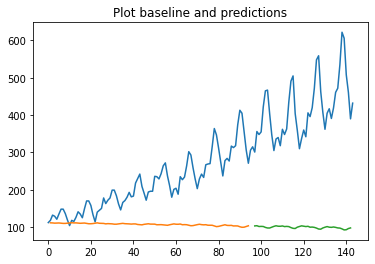

In [11]:
# Hacer un shift de las predicciones de entrenamiento para el plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# Hacer un shift de las predicciones de test para el plot
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# Representar las predicciones
plt.title("Plot baseline and predictions")
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



Como podemos ver, la red ha hecho un magnífico trabajo.